In [1]:
import sys
sys.path.append('../')

import controller
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
MODE = 3
MODE_DICT = {0: "Training Neural Model", 1: "Demonstrate Neural Model", 
             2: "Demonstrate Simple Equation", 3: "Test Neural Model",
             4: "Test Simple Equation"}
print(MODE_DICT[MODE])

Test Neural Model


In [3]:
CAR_MODEL = "complex"
ci = controller.Car_Interface(model = CAR_MODEL)

ci.set_gear(ci.FORWARD)

In [4]:
np.random.seed(181)

def accelerate_until_velocity(ci, target_vel):
    while(len(ci.log["velocity"]) == 0 or ci.log["velocity"][-1] < target_vel):
        ci.apply_control(pedal = ci.ACCELERATOR, amount = 1.0)

def stopping_distance_gen(ci, t = 50):
    amt = 0.15 + random.random() * 0.85
    initial_velocity = random.random()

    accelerate_until_velocity(ci, initial_velocity)
    initial_velocity = ci.log["velocity"][-1]
    ci.zero_position()
    ci.apply_control_for_time(pedal = ci.BRAKE, amount = amt, time = t)

    stopping_distance = ci.log["position"][-1]
    inp = [initial_velocity, stopping_distance]

    return amt, inp

In [5]:
amt, (initial_velocity, stopping_distance) = stopping_distance_gen(ci)
print(f"A car moving at {initial_velocity * 100:.2f}% speed, applied {amt * 100:.2f}% brakes and stopped, after travelling {stopping_distance:.2f} distance units")

A car moving at 59.50% speed, applied 67.13% brakes and stopped, after travelling 1.85 distance units


In [6]:
def actual_stopping_distance(initial_velocity, amt):
    x = ci.brake_weight * amt + ci.rolling_bias
    f = ci.friction_constant
    v0 = initial_velocity
    
    if ((1-f*v0/x) < 0):
        return float("inf")
    
    d = ((x/f)*np.log(1-f*v0/x) + v0)/f
    return d

def approximate_amount(inp, tol = 1e-5, min_amt = 0, max_amt = 1):
    mid_amt = (min_amt + max_amt) / 2
    if (max_amt - min_amt < 2 * tol):
        return mid_amt

    v0, stopping_distance = inp
    if (actual_stopping_distance(v0, mid_amt) < stopping_distance):
        return approximate_amount(inp, tol, min_amt, mid_amt)
    else:
        return approximate_amount(inp, tol, mid_amt, max_amt)

In [7]:
if (MODE == 4):
    for i in range(3):
            amt, (initial_velocity, stopping_distance) = stopping_distance_gen(ci)
            pred = approximate_amount((initial_velocity, stopping_distance))
            print(f"Car moving at {initial_velocity * 100:.2f}%; Target Stopping Distance {stopping_distance:.2f} distance units")
            print(f"Simulation Brake Amount: {amt*100:.2f}%; Closed Form Brake Amount {pred*100:.2f}%")
            print()

In [8]:
class fcn(nn.Module):

    def __init__(self):
        super().__init__()

        self.H_1 = 30
        self.H_2 = 20

        self.W_1 = nn.Parameter(torch.randn([2, self.H_1]))
        self.B_1 = nn.Parameter(torch.randn([self.H_1]))

        self.W_2 = nn.Parameter(torch.randn([self.H_1, self.H_2]))
        self.B_2 = nn.Parameter(torch.randn([self.H_2]))

        self.W_3 = nn.Parameter(torch.randn([self.H_2, 1]))
        self.B_3 = nn.Parameter(torch.randn([1]))

    def forward(self, x):

        x = torch.tensor(x, dtype = torch.float32)

        h_1 = torch.tanh(torch.matmul(x, self.W_1) + self.B_1)

        h_2 = torch.tanh(torch.matmul(h_1, self.W_2) + self.B_2)

        out = torch.squeeze(torch.matmul(h_2, self.W_3) + self.B_3)

        return 1.15 * torch.sigmoid(out)

In [9]:
if (MODE == 1 or MODE == 3):
    FN = "weights_" + CAR_MODEL

    model = fcn()
    model.load_state_dict(torch.load(open(FN + ".pt", "rb")))

In [10]:
if (MODE == 0):
    NUM_BATCHES = 10
    BATCH_SIZE = 30
    EPOCHS = 10


    USE_LAST = True

    FN = "weights_" + CAR_MODEL

    model = fcn()
    if(USE_LAST):
        model.load_state_dict(torch.load(open(FN + ".pt", "rb")))

    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

    for e in range(EPOCHS):
        e_loss = 0
        for b in range(NUM_BATCHES):
            b_loss = 0
            for i in range(BATCH_SIZE):
                amt, inp = stopping_distance_gen(ci)

                out = model(inp)

                amt_t = torch.tensor(amt)
                b_loss += (out - amt_t) ** 2

            b_loss /= BATCH_SIZE

            optimizer.zero_grad()
            b_loss.backward()
            optimizer.step()

            b_loss = b_loss.detach().numpy()
            print(f"B {b} L {b_loss:.4f}", end = "\r")
            e_loss += b_loss

        e_loss /= NUM_BATCHES
        print(f"EPOCH {e + 1} {e_loss:.4f}")

        torch.save(model.state_dict(), open(FN + ".pt", "wb"))

In [11]:
if (MODE == 1 or MODE == 2):
    DEM = 5

    for i in range(DEM):

        amt, inp = stopping_distance_gen(ci)

        if (MODE == 1):
            out = model(inp).detach().numpy()
        elif (MODE == 2):
            out = approximate_amount(inp, tol = 1e-5)

        print(f"INIT VEL: {inp[0]:.3f} TARG SD: {inp[1]:.3f} BRK AMT: {amt:.3f} MODEL OUT:{out:.3f} ")

WITHIN 0.1 279/300 times
AVERAGE ERROR 0.038271228773126


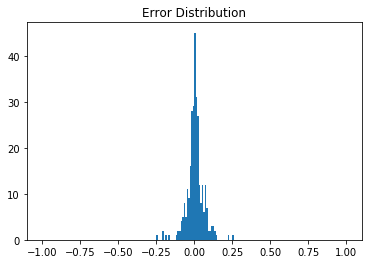

In [12]:
if (MODE == 3 or MODE == 4):
    TEST = 300
    correct = 0
    tol = 0.1
    errors = []
    for i in range(TEST):
        print(f"TESTING {i + 1}/{TEST}", end = "\r")
        amt, inp = stopping_distance_gen(ci)

        if (MODE == 3):
            out = model(inp).detach().numpy()
        elif (MODE == 4):
            out = approximate_amount(inp, tol = 1e-5)

        if (abs(out - amt) < tol):
            correct += 1
        errors.append(out - amt)
    print(f"WITHIN {tol} {correct}/{TEST} times")
    print(f"AVERAGE ERROR {np.mean(np.abs(errors))}")

    plt.title("Error Distribution")
    plt.hist(errors, bins = 200, range = (-1, 1))
    plt.show()